# Math Discriminator Content

In [56]:
import numpy as np
from math_vocab import MathVocab
from math_discr_dataset import MathDiscrDataset

disc_key         = 'false' # random false
voc_path         = "data/math/math_vocab.data"
tr_dataset_paths = ("data/math/math_dataset_train.data", "data/math/math_%s_dataset_train.data" % disc_key)
va_dataset_paths = ("data/math/math_dataset_valid.data", "data/math/math_%s_dataset_valid.data" % disc_key)
emb_path         = "data/math/math_embeddings.npy"
model_path       = 'models/math/dcont-001/'

## Data

In [57]:
voc = MathVocab()
voc.restore(voc_path)

tr_dataset = MathDiscrDataset(*tr_dataset_paths)
va_dataset = MathDiscrDataset(*va_dataset_paths)

embeddings = np.load(emb_path) 
print(tr_dataset)
print(embeddings.shape)

MathDiscrDataset:
  shape: [20000, 34]
(17, 100)


## Model

In [58]:
def make_rnn_cell(num_units, num_layers, keep_prob):
    def make_layer():
        l = tf.contrib.rnn.BasicLSTMCell(num_units)
        l = tf.contrib.rnn.DropoutWrapper(l, output_keep_prob=keep_prob)
        return l        
    layers = [make_layer() for _ in range(num_layers)]
    cell   = tf.contrib.rnn.MultiRNNCell(layers)
    return cell


def make_encoder(inp, num_units, num_layers, batch_size, seq_len, keep_prob):
    en_cell            = make_rnn_cell(num_units, num_layers, keep_prob)
    en_initial_state   = en_cell.zero_state(batch_size, tf.float32)
    seq_lens           = tf.tile([seq_len], tf.expand_dims(batch_size,0))
    _, en_state        = tf.nn.dynamic_rnn(en_cell, inp, seq_lens, en_initial_state, scope='encoder')
    return en_state

In [59]:
import os
from utils import make_dir
import numpy as np
import tensorflow as tf
import pickle
from visualization import show_train_stats_ex

class BaseModel:
    def __init__(self):
        self._scope    = 'base_model'
        # state
        self.tr_step   = 0
        self.tr_epoch  = 0
        self.tr_losses = []
        self.va_losses = []
    
    def _make_optimizer(self, loss, lr, grad_clip):
        tr_vars   = tf.trainable_variables()
        grads, _  = tf.clip_by_global_norm(tf.gradients(loss, tr_vars), grad_clip)
        train_op  = tf.train.AdamOptimizer(lr)
        optimizer = train_op.apply_gradients(zip(grads, tr_vars))
        return optimizer

    def _make_train_feeder(self, *args):
        raise NotImplementedError
        
    def train(self, tr_dataset, va_dataset, 
              step_num,  batch_size, learning_rate, keep_prob=.5, log_every=20, mean_win=30):
        try:
            data_size = tr_dataset.get_data_size()
            for self.tr_step in range(self.tr_step, step_num-1):
                ep = self.tr_step*batch_size/data_size
                # Train
                batch = tr_dataset.get_next_batch(batch_size)
                tr_loss, _ = self._sess.run(
                    [self.loss_op, self.train_op], 
                    feed_dict = self._make_train_feeder(batch, learning_rate, keep_prob))
                self.tr_losses.append(tr_loss)
                # Eval
                if self.tr_step % log_every == log_every-1:
                    batch = va_dataset.get_next_batch(batch_size)
                    va_loss = self._sess.run(
                        self.loss_op, 
                        feed_dict = self._make_train_feeder(batch, learning_rate, keep_prob))
                    self.va_losses.extend([va_loss]*log_every)
                    show_train_stats_ex(ep, self.tr_step, self.tr_losses, self.va_losses, mean_win)
        except KeyboardInterrupt:
            show_train_stats_ex(ep, self.tr_step, self.tr_losses, self.va_losses, mean_win)
            
    def save(self, path):
        make_dir(path)
        pickle.dump([self.tr_epoch, self.tr_step, self.tr_losses, self.va_losses], 
                    open(os.path.join(path, "state.p"), "wb"))
        self._saver.save(self._sess, path)
        
        
    def restore(self, path):
        try:
            [self.tr_epoch, self.tr_step, self.tr_losses, self.va_losses] = pickle.load(
                open(os.path.join(path, "state.p"), "rb"))
        except: 
            print("State not found at", path)
        self._saver.restore(self._sess, path)

In [60]:
class DcontModel(BaseModel):
    def __init__(self):
        super().__init__()
        self._scope = 'dcont_model'
    
    
    def build(self, voc_size, emb_size, seq_len, num_units, num_layers, grad_clip=5):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default(), tf.variable_scope(self._scope):
            # placeholders
            self.enc_inputs_pl = tf.placeholder(tf.int32, [None, None], name='enc_inputs')
            self.targets_pl    = tf.placeholder(tf.int32, [None], name='targets')
            self.batch_size_pl = tf.placeholder(tf.int32, shape=[], name='batch_size')
            self.keep_prob_pl  = tf.placeholder(tf.float32, name='keep_prob')
            self.lr_pl         = tf.placeholder(tf.float32, name='learning_rate')

            # embedding
            # self.embedding = tf.Variable(tf.random_normal(shape=[voc_size, emb_size], dtype=tf.float32))
            self.embedding = tf.constant(embeddings, dtype=tf.float32)
            
            # encoder
            enc_state = make_encoder(
                inp        = tf.nn.embedding_lookup(self.embedding, self.enc_inputs_pl),
                num_units  = num_units,
                num_layers = num_layers,
                batch_size = self.batch_size_pl,
                seq_len    = seq_len,
                keep_prob  = self.keep_prob_pl,
            )
            enc_outputs = tf.identity(enc_state[-1].h, name="enc_outputs")
            
            # discriminator
            l = tf.layers.dense(enc_outputs, units=1024, activation=tf.nn.relu)
            logits = tf.layers.dense(l, units=2, activation=None)
            self.outputs = tf.argmax(logits, 1)

            # training
            cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = logits,
                labels = self.targets_pl
            )
            self.loss_op  = tf.reduce_mean(cross_entropy)
            self.train_op = self._make_optimizer(self.loss_op, self.lr_pl, grad_clip)
            
            # utils
            self.init_op = tf.global_variables_initializer()
            self._saver  = tf.train.Saver()

        # session
        self._sess = tf.Session(graph=self._graph)
        self._sess.run(self.init_op)
        
    def _make_train_feeder(self, batch, learning_rate, keep_prob):
        sents, labels = batch
        return {
            self.enc_inputs_pl: sents,
            self.targets_pl   : labels,
            self.batch_size_pl: len(sents),
            self.keep_prob_pl : keep_prob,
            self.lr_pl        : learning_rate,
        }
    
    def infer(self, sents):
        return self._sess.run(
            self.outputs, 
            feed_dict = {
                self.enc_inputs_pl: sents,
                self.batch_size_pl: len(sents),
                self.keep_prob_pl : 1,
        })

## Build

In [ ]:
model = DcontModel()
seq_len = tr_dataset.get_seq_len()

model.build(
    voc_size   = voc.size, 
    seq_len    = seq_len,
    emb_size   = 100, 
    num_units  = 256, 
    num_layers = 2,
)

## Train

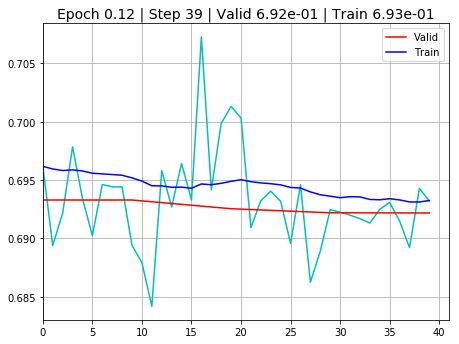

In [ ]:
%%time
%matplotlib inline

model.train(
    step_num      = 100000,
    batch_size    = 64, 
    learning_rate = 1e-5, 
    mean_win      = 30,
    log_every     = 10,
    tr_dataset    = tr_dataset,
    va_dataset    = va_dataset,
)
model.save(model_path)

## Test

In [55]:
batch_size = 20

for dataset in [tr_dataset, va_dataset]:
    print('\n'+'='*80+'\n')
    inp, true = dataset.get_next_batch(batch_size)
    pred = model.infer(inp)

    def prepare(s):
        words = voc.to_words(s)
        s = "".join(words)
        s = s.replace('<BOS>', '[').replace('<EOS>', ']').replace('<PAD>', '_')
        return s

    for i in range(len(inp)):
        print(prepare(inp[i]), pred[i], "" if pred[i]==true[i] else "ERROR")




[10+1+2 = 1+12]___________________ 1 
[11+2 = 10+1+2]___________________ 1 
[13+1+1 = 2+6+2+5]________________ 1 
[3+8 = 2+5+4]_____________________ 1 
[15 = 9+2+1+3]____________________ 1 
[1+9+1+1 = 2+3+3+4]_______________ 1 
[19 = 7+2+8+2]____________________ 1 
[15 = 1+13+1]_____________________ 1 
[14+3 = 9+1+7]____________________ 1 
[10+1+1 = 1+1+10]_________________ 1 
[9+2 = 2+4+4+1]___________________ 1 
[29+77++91+57+810++++67]__________ 0 
[12+1+1 = 2+10+2]_________________ 1 
[10 = 2+3+5]______________________ 1 
[5+69922+++8++6+7 =0++++9190]_____ 0 
[17+1 = 8+3+5+2]__________________ 1 
[7+1+1+1 = 1+1+7+1]_______________ 1 
[+09++++6 0+ + 31= +++2=5+5=5]____ 0 
[3+95+8994286+4+=+=740+++ ++]_____ 0 
[731++2+]_________________________ 0 


[25+ 60=8+1]______________________ 0 
[3+14 +4]_________________________ 0 
[4+2+13 = 1+1+4+1+12]_____________ 1 
[8+1+1 = 10]______________________ 1 
[6 82]____________________________ 0 
[8+4 = 3+8+1]_____________________ 1 
[+9++95+

## Restore

In [53]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/rnn_autoencoder/math-001/
